In [35]:
using CSV, DataFrames, Statistics, Dates, Plots, LinearAlgebra, DecisionTree, Random

In [126]:
trainData = CSV.read("./data/train.csv", DataFrame)
testData = CSV.read("./data/test.csv", DataFrame)
first(trainData, 5)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2023,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"
2,2020,VUS_petit,4,2,integrale,automatique,"9,80041666666667"
3,2021,voiture_compacte,6,"3,3",propulsion,automatique,"11,7605"
4,2023,voiture_deux_places,8,5,integrale,automatique,"13,0672222222222"
5,2022,voiture_moyenne,8,"4,4",integrale,automatique,"13,8358823529412"


In [127]:
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => ".")) 

testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))

150-element Vector{Float64}:
 2.5
 2.5
 2.5
 2.0
 5.8
 5.0
 5.0
 2.4
 3.5
 5.2
 5.2
 5.9
 2.0
 ⋮
 1.6
 3.3
 5.0
 2.0
 2.0
 1.6
 2.0
 2.0
 3.0
 3.0
 1.5
 2.0

In [128]:
possibles = sort(unique(trainData.consommation))

25-element Vector{Float64}:
  4.52326923076923
  4.90020833333333
  6.35702702702703
  6.53361111111111
  6.91794117647059
  7.12757575757576
  7.3503125
  7.58741935483871
  7.84033333333333
  8.11068965517241
  8.40035714285714
  8.71148148148148
  9.04653846153846
  9.4084
  9.80041666666667
 10.2265217391304
 10.6913636363636
 11.2004761904762
 11.7605
 12.3794736842105
 13.0672222222222
 13.8358823529412
 14.700625
 15.6806666666667
 16.8007142857143

In [ ]:
#= findnearest(A::Vector{Float64},t::Float64) = A[findmin(broadcast(abs,A.-t))[2]] =#

findnearest (generic function with 1 method)

In [130]:
trainData[!,:volume_gaz] = trainData[!,:nombre_cylindres] .* trainData[!,:cylindree]

testData[!,:volume_gaz] = testData[!,:nombre_cylindres] .* testData[!,:cylindree]

150-element Vector{Float64}:
 10.0
 10.0
 10.0
  8.0
 46.4
 40.0
 40.0
  9.6
 21.0
 52.0
 52.0
 70.80000000000001
  8.0
  ⋮
  6.4
 19.799999999999997
 40.0
  8.0
  8.0
  6.4
  8.0
  8.0
 18.0
 18.0
  4.5
  8.0

In [131]:
function train_test_split(data, test_size=0.2, shuffle=true)
    n = size(data, 1)
    test_size = floor(Int, n * test_size)
    
    if shuffle
        indices = randperm(n)
    else
        indices = 1:n
    end
    
    test_indices = indices[1:test_size]
    train_indices = indices[test_size+1:end]
    
    train_data = data[train_indices, :]
    test_data = data[test_indices, :]
    
    return train_data, test_data
end

train_test_split (generic function with 3 methods)

In [41]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end

function encode_class(data)
    return map(x -> findfirst(y -> y==x, possibles) , data.consommation)
end

function decode_class(data)
    return map(x -> possibles[x], data)
end

function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    encoded_data = encode(encoded_data, :nombre_cylindres)

    return encoded_data
end

function removeRows(data)
    return select!(data, Not([:type, :transmission, :boite, :nombre_cylindres]))
end

function normalize_column(data, column)
    data[!, column] = (data[!, column] .- mean(data[!, column])) ./ std(data[!, column])
    return data
end

function norm_cols(data)
    normalized_data = deepcopy(data)
    normalized_data = normalize_column(normalized_data, :cylindree)
    normalized_data = normalize_column(normalized_data, :volume_gaz)
    return normalized_data
end

norm_cols (generic function with 1 method)

chose à faire:

1. retirer les dupliqués dans le train set par moyenne
2. assigner la valeur du train set pour les dupliqués du train et test set
3. seulement train sur les données uniques

In [132]:
#= trainData[trainData.annee .== 2014 .&& trainData.type .== "voiture_sous_compacte", :]
 =#
#fuse duplicates in trainData and conommation by mean
#= trainData = by(trainData, [:consommation, :cylindree, :volume_gaz, :type, :transmission, :boite, :nombre_cylindres], df -> DataFrame(prix = mean(df.prix), annee = mean(df.annee)))
 =#
trainData = combine(x -> mean(x.consommation), groupby(trainData, [ :annee, :cylindree, :volume_gaz, :type, :transmission, :boite, :nombre_cylindres]))
rename!(trainData, :x1 => :consommation)


Row,annee,cylindree,volume_gaz,type,transmission,boite,nombre_cylindres,consommation
,Int64,Float64,Float64,String31,String15,String15,Int64,Float64
1,2023,4.4,35.2,voiture_moyenne,integrale,automatique,8,12.8649
2,2020,2.0,8.0,VUS_petit,integrale,automatique,4,10.0909
3,2021,3.3,19.8,voiture_compacte,propulsion,automatique,6,11.7605
4,2023,5.0,40.0,voiture_deux_places,integrale,automatique,8,13.0672
5,2022,4.4,35.2,voiture_moyenne,integrale,automatique,8,13.8359
6,2022,1.5,4.5,voiture_minicompacte,traction,automatique,3,7.35031
7,2024,1.5,4.5,voiture_minicompacte,traction,manuelle,3,7.58742
8,2020,3.8,22.8,VUS_standard,integrale,automatique,6,11.2005
9,2019,3.3,19.8,voiture_compacte,propulsion,automatique,6,11.7605


In [134]:
#mettre dans testData la moyenne des valeurs qui ont déjà apparues dans trainData
testData = DataFrames.leftjoin(testData,unique(trainData), on = [:annee,	:type,	:nombre_cylindres,	:cylindree,	:transmission,	:boite,	:volume_gaz])

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,volume_gaz,consommation
,Int64,String31,Int64,Float64,String15,String15,Float64,Float64?
1,2020,VUS_petit,4,2.0,integrale,automatique,8.0,10.0909
2,2020,VUS_petit,4,2.0,integrale,automatique,8.0,10.0909
3,2023,VUS_standard,8,5.0,4x4,automatique,40.0,14.7006
4,2024,voiture_sous_compacte,6,3.0,propulsion,automatique,18.0,11.0899
5,2020,voiture_moyenne,4,2.0,integrale,automatique,8.0,8.71148
6,2015,VUS_standard,8,6.2,4x4,automatique,49.6,14.7006
7,2015,VUS_standard,8,6.2,4x4,automatique,49.6,14.7006
8,2019,VUS_petit,4,2.4,integrale,automatique,9.6,9.80042
9,2021,VUS_petit,4,2.0,traction,automatique,8.0,7.58742


In [ ]:
#SANS L'ANNEE
#= testData = DataFrames.leftjoin(testData[:, Not(:annee)],unique(trainData), on = [	:type,	:nombre_cylindres,	:cylindree,	:transmission,	:boite,	:volume_gaz])[:, Not(:annee)] =#

In [94]:
encoded_train = trainData
#encoded_train = unique(encoded_train)
#encoded_train = encode_data(encoded_train)
#encoded_train = removeRows(encoded_train)
#encoded_train.consommation = encode_class(trainData)

#encoded_train.cylindree = encoded_train.cylindree .- minimum(encoded_train.cylindree)
#encoded_train.volume_gaz = encoded_train.volume_gaz .- minimum(encoded_train.volume_gaz)
#encoded_train.annee = encoded_train.annee .-minimum(encoded_train.annee)


train, test= train_test_split(encoded_train)


#= encoded_train =#

X_train =  Matrix(train[:, Not(:consommation)])
y_train = train.consommation
X_test = Matrix(test[:, Not(:consommation)])
y_test = test.consommation

size(X_test),size(X_train),size(y_test),size(y_train)

((55, 7), (223, 7), (55,), (223,))

In [136]:
#le nb de Missing dans le train et le test
ismissing.(testData.consommation) |> sum

74

In [145]:
    train, test= train_test_split(encoded_train)

    X_train =  Matrix(train[:, Not(:consommation)])
    y_train = train.consommation
    X_test = Matrix(test[:, Not(:consommation)])
    y_test = test.consommation


    model = RandomForestClassifier()
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    #rmse
    println(sqrt(mean((y_pred .- y_test).^2)))
    #sqrt(mean((decode_class(y_pred) - decode_class(test.consommation)).^2))


0.8386407174308851


In [154]:
println(decode_class(y_pred))
println(decode_class(test.consommation))

[12.3794736842105, 7.12757575757576, 10.6913636363636, 10.2265217391304, 13.8358823529412, 8.71148148148148, 10.2265217391304, 9.04653846153846, 11.2004761904762, 7.58741935483871, 12.3794736842105, 10.6913636363636, 10.2265217391304, 10.2265217391304, 9.04653846153846, 11.7605, 9.80041666666667, 8.11068965517241, 10.2265217391304, 9.80041666666667, 13.0672222222222, 10.2265217391304, 13.8358823529412, 11.2004761904762, 13.0672222222222, 13.0672222222222, 10.6913636363636, 10.2265217391304, 9.04653846153846, 9.04653846153846, 9.04653846153846, 11.7605, 11.2004761904762, 11.2004761904762, 9.4084, 7.12757575757576, 11.2004761904762, 9.4084, 9.4084, 8.11068965517241, 10.6913636363636, 9.04653846153846, 8.71148148148148, 13.8358823529412, 10.2265217391304, 15.6806666666667, 9.04653846153846, 9.4084, 7.84033333333333, 7.58741935483871, 13.0672222222222, 9.80041666666667, 7.58741935483871, 13.8358823529412, 13.0672222222222, 11.2004761904762, 13.8358823529412, 8.71148148148148, 11.2004761904

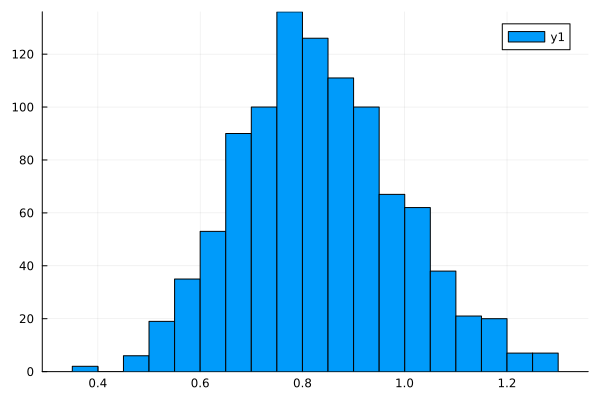

In [146]:
n = []
for i in 1:1000
    train, test= train_test_split(encoded_train,0.1)

    X_train =  Matrix(train[:, Not(:consommation)])
    y_train = train.consommation
    X_test = Matrix(test[:, Not(:consommation)])
    y_test = test.consommation


    model = RandomForestClassifier(n_subfeatures=6, n_trees=10,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    #= push!(n,sqrt(mean((decode_class(y_pred) - decode_class(test.consommation)).^2)))
 =#
    push!(n,sqrt(mean((y_pred .- y_test).^2)))
end
histogram(n)

In [148]:
n = 0
for i in 1:100
    train, test= train_test_split(encoded_train)

    X_train =  Matrix(train[:, Not(:consommation)])
    y_train = train.consommation
    X_test = Matrix(test[:, Not(:consommation)])
    y_test = test.consommation


    model = RandomForestRegressor(n_subfeatures=7, n_trees=600,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    #println(y_pred)
    y_pred_adjusted = map(x -> findnearest(possibles,x),y_pred)
    n += sqrt(mean((y_pred_adjusted - test.consommation).^2))
end
println(n/100)

0.8334548269164311


In [ ]:

res = []
for i in 1:20
    n = 0
    for i in 1:10
        model = RandomForestRegressor(n_trees=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - y_test).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(1:20, res, label="RandomForestRegressor", xlabel="n_trees", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [ ]:

res = []
for i in 1:23
    n = 0
    for j in 1:10
        model = RandomForestRegressor(n_subfeatures=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - test.consommation).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(1:23, res, label="RandomForestRegressor", xlabel="n_subfeatures", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [ ]:
res = []
for i in 1:23
    n = 0
    for j in 1:10
        model = RandomForestRegressor(min_samples_leaf=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - test.consommation).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(1:23, res, label="RandomForestRegressor", xlabel="min_samples_leaf", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [ ]:
res = []
for i in 1:23
    n = 0
    for j in 1:10
        model = RandomForestRegressor(min_purity_increase=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - test.consommation).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(1:23, res, label="RandomForestRegressor", xlabel="min_samples_leaf", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [ ]:
res = []
for i in 2:23
    n = 0
    for j in 1:10
        model = RandomForestRegressor(min_samples_split=i)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)
    n += sqrt(mean((y_pred - test.consommation).^2))
    end
    push!(res,n/10)
end



# display the grid
plot(2:23, res, label="RandomForestRegressor", xlabel="min_samples_leaf", ylabel="RMSE", title="RandomForestRegressor RMSE vs n_trees")

In [119]:
@doc RandomForestRegressor

```
RandomForestRegressor(; n_subfeatures::Int=-1,
                      n_trees::Int=10,
                      partial_sampling::Float=0.7,
                      max_depth::Int=-1,
                      min_samples_leaf::Int=5,
                      rng=Random.GLOBAL_RNG,
                      impurity_importance::Bool=true)
```

Random forest regression. See [DecisionTree.jl's documentation](https://github.com/bensadeghi/DecisionTree.jl)

Hyperparameters:

  * `n_subfeatures`: number of features to consider at random per split (default: -1, sqrt(# features))
  * `n_trees`: number of trees to train (default: 10)
  * `partial_sampling`: fraction of samples to train each tree on (default: 0.7)
  * `max_depth`: maximum depth of the decision trees (default: no maximum)
  * `min_samples_leaf`: the minimum number of samples each leaf needs to have (default: 5)
  * `min_samples_split`: the minimum number of samples in needed for a split
  * `min_purity_increase`: minimum purity needed for a split
  * `rng`: the random number generator to use. Can be an `Int`, which will be used to seed and create a new random number generator. Multi-threaded forests must be seeded with an `Int`
  * `impurity_importance`: whether to calculate feature importances using `Mean Decrease in Impurity (MDI)`. See [`DecisionTree.impurity_importance`](@ref).

Implements `fit!`, `predict`, `get_classes`


In [488]:
@doc DecisionTreeRegressor

```
DecisionTreeRegressor(; pruning_purity_threshold=0.0,
                      max_depth::Int-1,
                      min_samples_leaf::Int=5,
                      min_samples_split::Int=2,
                      min_purity_increase::Float=0.0,
                      n_subfeatures::Int=0,
                      rng=Random.GLOBAL_RNG,
                      impurity_importance::Bool=true)
```

Decision tree regression. See [DecisionTree.jl's documentation](https://github.com/bensadeghi/DecisionTree.jl)

Hyperparameters:

  * `pruning_purity_threshold`: (post-pruning) merge leaves having `>=thresh` combined purity (default: no pruning). This accuracy-based method may not be appropriate for regression tree.
  * `max_depth`: maximum depth of the decision tree (default: no maximum)
  * `min_samples_leaf`: the minimum number of samples each leaf needs to have (default: 5)
  * `min_samples_split`: the minimum number of samples in needed for a split (default: 2)
  * `min_purity_increase`: minimum purity needed for a split (default: 0.0)
  * `n_subfeatures`: number of features to select at random (default: keep all)
  * `rng`: the random number generator to use. Can be an `Int`, which will be used to seed and create a new random number generator.
  * `impurity_importance`: whether to calculate feature importances using `Mean Decrease in Impurity (MDI)`. See [`DecisionTree.impurity_importance`](@ref)

Implements `fit!`, `predict`, `get_classes`


In [ ]:
model = DecisionTreeRegressor(n_subfeatures=12, min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6,)
DecisionTree.fit!(model, X_train, y_train)
y_pred = DecisionTree.predict(model, X_test)
sqrt(mean((y_pred - test.consommation).^2))

1.1704408817014724

In [456]:
y_pred

79-element Vector{Float64}:
  1.2240951129805515
  0.17625130984704987
  1.479696235370256
 -0.2607463003952433
  1.5211869207713695
 -1.3097410769834612
 -1.376475788529015
 -1.3608160998913268
  0.6165740389681241
 -1.2787160338849795
  1.4209770672951387
  1.7941338351390625
  0.3887079431074021
  ⋮
  0.37544214897858164
 -1.5136770521451326
 -1.079500521944099
  1.174229577971678
 -1.0333093095750074
 -0.01294650848269291
 -1.2879443398905748
 -1.4793632637667964
  1.2431097360103887
 -1.304503701086083
 -0.8312720241469432
 -1.2995868865253335

In [21]:
id = 1:150

df_pred = DataFrame(id=id, consommation=res)

CSV.write("benchmark1.csv", df_pred)

"benchmark1.csv"